In [4]:
%pylab inline

import sys
sys.path.append('../src/')
import leapfrog_bfe 
from gala import potential as gp
from astropy import units as u
import scipy.linalg as la 
import gala.dynamics as gd


from gala.potential.scf import compute_coeffs
from profiles import Hernquist 
from gala.units import galactic
from profiles import G

import bfe_fields as bfe

Populating the interactive namespace from numpy and matplotlib


In [2]:
figs_path = "../../time-dependent-scf/notebooks/figures/intertial_vs_non-intertial_ex/"

# SCF vs gala static 

In [3]:
# satellite halo
def density_func(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2) # * u.kpc
    M = 1E11 # u.Msun 
    rs = 1 #*u.kpc
    rho0 = M/(2*np.pi*rs**3)
    return rho0 / ((r/rs) *(1+r/rs)**3)

nmax=10
lmax=1
scf_coeffs = compute_coeffs(density_func, nmax=nmax, lmax=lmax, M=1E11, r_s=1)
S = scf_coeffs[0][0]
T = scf_coeffs[1][0]

# SCF composite static

In [11]:

def density_func_host(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2) # * u.kpc
    M = 1E12 # u.Msun 
    rs = 1 #*u.kpc
    rho0 = M/(2*np.pi*rs**3)
    return rho0 / ((r/rs) *(1+r/rs)**3)

nmax=10
lmax=1
scf_coeffs_host = compute_coeffs(density_func_host, nmax=nmax, lmax=lmax, M=1E12, r_s=1)
S_sat = scf_coeffs_host[0][0]
T_sat = scf_coeffs_host[1][0]

# SCF time-dependent

In [1]:

def run_gala_orbit(pos_tp, vel_tp, pos_sat, vel_sat):
    """
    Specify units in ICs
    """
    ## GALA set up

    # Design gala potential using Nbody and a test particle


    # Present-day position/velocity in inertial frame moving with instantaneous 
    # Milky Way velocity:
    w0_mw = gd.PhaseSpacePosition(
        pos=[0, 0, 0]*u.kpc,
        vel=[0, 0, 0]*u.km/u.s,
    )
    pot_mw = gp.HernquistPotential(m=1e12*u.Msun, c=1*u.kpc, units=galactic)

    # Values from Vasiliev et al. 2020
    w0_lmc = gd.PhaseSpacePosition(
        pos=pos_sat,
        vel=vel_sat,
    )

    w0_test = gd.PhaseSpacePosition(
        pos=pos_tp,
        vel=vel_tp,
    )


    pot_lmc = gp.HernquistPotential(m=1e11*u.Msun, c=1*u.kpc, units=galactic)

    w0 = gd.combine((w0_mw, w0_lmc, w0_test))
    nbody = gd.DirectNBody(w0, [pot_mw, pot_lmc, None])

    w1 = gd.combine((w0_lmc, w0_test))
    isolated = gd.DirectNBody(w1, [pot_lmc, None])

    dt = 0.1*u.Myr
    tmax = 8*u.Gyr
    nsteps = int((tmax/dt).to(u.Gyr/u.Gyr).value)
    t_orbit = np.linspace(0, tmax, nsteps)


    # Full : Host - Satellite - test particle 
    orbits = nbody.integrate_orbit(dt=dt, t1=0*u.Gyr, t2=tmax)


    # Orbit quantities full orbit 
    pos_halo = np.array([orbits.xyz[:,:,0].to(u.kpc).value])
    pos_sat = np.array([orbits.xyz[:,:,1].to(u.kpc).value])
    pos_tp = np.array([orbits.xyz[:,:,2].to(u.kpc).value])

    vel_halo = np.array([orbits.v_xyz[:,:,0].to(u.km/u.s).value])
    vel_sat = np.array([orbits.v_xyz[:,:,1].to(u.km/u.s).value])
    vel_tp = np.array([orbits.v_xyz[:,:,2].to(u.km/u.s).value])


    r_halo = (np.sum(orbits.xyz[:,:,0]**2, axis=0))**0.5
    r_sat = (np.sum(orbits.xyz[:,:,1]**2, axis=0))**0.5
    r_tp = (np.sum(orbits.xyz[:,:,2]**2, axis=0))**0.5

    v_halo = (np.sum(orbits.v_xyz[:,:,0].to(u.km/u.s).value**2, axis=0))**0.5
    v_sat = (np.sum(orbits.v_xyz[:,:,1].to(u.km/u.s).value**2, axis=0))**0.5
    v_tp = (np.sum(orbits.v_xyz[:,:,2].to(u.km/u.s).value**2, axis=0))**0.5


    rtp_r2_sat = np.sum((np.array(orbits.xyz[:,:,2].to(u.kpc).value-orbits.xyz[:,:,1].to(u.kpc).value))**2, axis=0)**0.5
    vtp_r2_sat = np.sum((np.array(orbits.v_xyz[:,:,2].to(u.km/u.s).value-orbits.v_xyz[:,:,1].to(u.km/u.s).value))**2, axis=0)**0.5
    
    return [pos_halo, vel_halo], [pos_sat, vel_sat], [pos_tp, vel_tp]

In [ ]:
def orbit_rest_frames(pos_host, pos_sat, pos_tp):
    # Host frame
    
    # Sat frame 
    
    # Origin frame
    
    return r_host, r_sat, r_origin


def orbits_plots():
    plot(pos_sat[0][0], pos_sat[0][1])
    
    
    ## 
    title('Satellite velocities', fontsize=18)
    plot(t_scft_com, vel_sat[0][0], label='vx')
    plot(t_scft_com, vel_sat[0][1], label='vy')
    plot(t_scft_com, vel_sat[0][2], label='vz')
    legend()
    
    
    
    ## Accelerations 

    plot(t_scft_com, ax_ru, label='$a_x$')
    plot(t_scft_com, ay_ru, label='$a_y$')
    title(r'$\rm{Halo\ COM\ acceleration}$', fontsize=25)
    xlabel('Time [Gyrs]')
    legend(fontsize=18)
    ylabel(r'Acceleration $\rm{kpc/Gyr^2}$')
    savefig(figs_path+"halo_com_acceleration.png", bbox_inches='tight')
    savefig(figs_path+"halo_com_acceleration.pdf", bbox_inches='tight')

In [23]:
# Define satellite COM motion 
sat_com = pos_sat[0].T - pos_sat[0][:,0]
sat_vcom = vel_sat[0].T - vel_sat[0][:,0]


# Define dt
dt = t_scft_com[1]-t_scft_com[0]
# Compute satellite accelerations#



ax_sat = np.diff(np.array([vel_sat[0][0]]), axis=1)/dt*u.km/u.s/u.Gyr
ay_sat = np.diff(np.array([vel_sat[0][1]]), axis=1)/dt*u.km/u.s/u.Gyr


# Transform to kpc/Gyr^2
ax_ru = np.zeros_like(t_scft_com)
ay_ru = np.zeros_like(t_scft_com)

ax_ru[1:] = ax_sat.to(u.kpc/u.Gyr**2).value
ay_ru[1:] = ay_sat.to(u.kpc/u.Gyr**2).value

-468.10636331629144 0.0


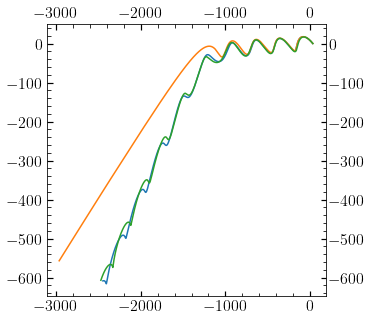

In [41]:
plot(x_scft_acom, y_scft_acom)
plot(x_scft_com, y_scft_com)
plot(pos_tp[0][0]-pos_tp[0][0][0]+30, pos_tp[0][1]-pos_tp[0][1][0])

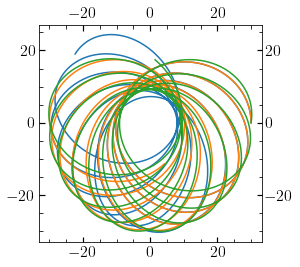

In [42]:
figsize(4, 4)

plot(pos_tp[0][0]-pos_sat[0][0], pos_tp[0][1]-pos_sat[0][1])
plot(x_scft, y_scft)
#plot(x_scft_com-sat_com[:,0], y_scft_com-sat_com[:,1])

plot(x_scft_acom-sat_com[:-1,0], y_scft_acom-sat_com[:-1,1])


Text(0, 0.5, 'Distance $\\rm{kpc}$')

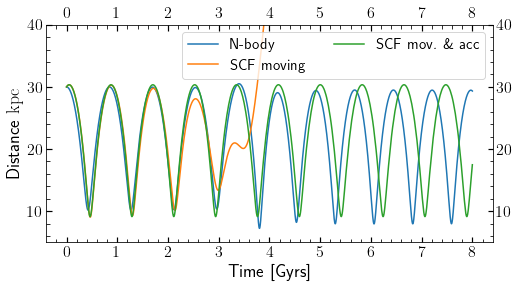

In [43]:
figsize(8, 4)
plot(t_scft_com, rtp_r2_sat, label='N-body')
plot(t_scft_com, r_scft_com_sat, label='SCF moving')
plot(t_scft_com[:-1], r_scft_acom_sat, label='SCF mov. \& acc')
#plot(t_scft_com[:-1], r_scft, label='Isolated')
legend(fontsize=15, ncol=2)
ylim(5, 40)


xlabel('Time [Gyrs]')
ylabel(r'Distance $\rm{kpc}$')
#savefig(figs_path+"nbody_vs_fictitous.png", bbox_inches='tight')

In [7]:
fig, ax = plt.subplot((2, 1))
ax[1].scatter(0, 0)

ax[0].scatter(1,1)

/tmp/ipykernel_43321/1544975095.py:1: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  fig,ax = plt.subplot((2, 1))


ValueError: Single argument to subplot must be a three-digit integer, not (2, 1)

<Figure size 432x288 with 0 Axes>